In [15]:
# lee el csv con todas las predicciones y obtiene métricas
import pandas as pd
import numpy as np

data = pd.read_csv("predictions_full.csv")
#data['netmhcpan4.1_pred_SB'] = data.apply(lambda row: (  1 if row['netmhcpan4.1_ligand'] == "SB" else 0  ), axis=1)
#data.to_csv("predictions2.csv", index=False)
print(data.head(3))

   id          HLA   peptide  Label  Length  \
0   1  HLA-A*01:01  LFGRDLSY      1       8   
1   2  HLA-A*01:01  TDKKTHLY      1       8   
2   3  HLA-A*01:01  RSDTPLIY      1       8   

                                  mhc  anthem_pred  anthem_prob  esm2t6_pred  \
0  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            0        0.819            1   
1  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            1        0.999            1   
2  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            1        0.999            1   

   esm2t6_prob  tape_pred  tape_prob  netmhcpan4.1_prob  netmhcpan4.1_rank  \
0     0.974380          1   0.876145           0.016228              3.731   
1     0.998730          1   0.997400           0.938144              0.036   
2     0.999896          1   0.996318           0.678749              0.165   

  netmhcpan4.1_ligand  netmhcpan4.1_pred_SB_WB  netmhcpan4.1_pred_SB  
0                   -                        0                     0  
1                  SB              

In [16]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.metrics import roc_auc_score

def get_metrics(y_test, y_test_predictions):
    accuracy = accuracy_score(y_test, y_test_predictions)
    precision = precision_score(y_test, y_test_predictions)
    recall = recall_score(y_test, y_test_predictions)
    f1score = f1_score(y_test, y_test_predictions)
    auc = roc_auc_score(y_test, y_test_predictions)
    conf_matrix = confusion_matrix(y_test, y_test_predictions)

    return {    "accuracy":accuracy, 
                "precision":precision, 
                "recall":recall, 
                "f1score":f1score, 
                "auc":auc, 
                "conf_matrix":conf_matrix}


metrics_anthem = get_metrics(data["Label"], data["anthem_pred"])
metrics_netmhcpan = get_metrics(data["Label"], data["netmhcpan4.1_pred_SB"])
metrics_tape = get_metrics(data["Label"], data["tape_pred"])
metrics_esm2t6 = get_metrics(data["Label"], data["esm2t6_pred"])
print(metrics_anthem)
print(metrics_netmhcpan)
print(metrics_tape)
print(metrics_esm2t6)


{'accuracy': 0.8811044153436087, 'precision': 0.9786196932327316, 'recall': 0.7787248867727325, 'f1score': 0.8673034514424663, 'auc': 0.8808912973241482, 'conf_matrix': array([[85005,  1465],
       [19054, 67056]])}
{'accuracy': 0.8312492756982269, 'precision': 0.9844103296441747, 'recall': 0.6724422250609685, 'f1score': 0.7990561025591488, 'auc': 0.8309186955072392, 'conf_matrix': array([[85553,   917],
       [28206, 57904]])}
{'accuracy': 0.9414822111484529, 'precision': 0.9352389459580169, 'recall': 0.9483915921495761, 'f1score': 0.9417693491936274, 'auc': 0.9414965940394, 'conf_matrix': array([[80815,  5655],
       [ 4444, 81666]])}
{'accuracy': 0.9401089349866728, 'precision': 0.9398305084745763, 'recall': 0.9401579375217745, 'f1score': 0.9399941944847605, 'auc': 0.9401090369926439, 'conf_matrix': array([[81287,  5183],
       [ 5153, 80957]])}


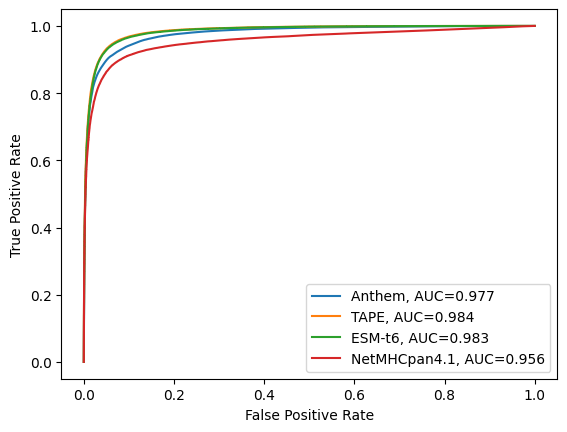

In [10]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

def plot_ROC(data_pd, file_name):
    y_test = data_pd["Label"]
    anthem = data_pd["anthem_prob"]
    esm2t6 = data_pd["esm2t6_prob"]
    tape = data_pd["tape_prob"]
    netmhcpan = data_pd["netmhcpan4.1_prob"]

    fpr1, tpr1, _ = metrics.roc_curve(y_test,  anthem)
    fpr2, tpr2, _ = metrics.roc_curve(y_test,  tape)
    fpr3, tpr3, _ = metrics.roc_curve(y_test,  esm2t6)
    fpr4, tpr4, _ = metrics.roc_curve(y_test,  netmhcpan)

    auc1 = metrics.roc_auc_score(y_test, anthem)
    auc2 = metrics.roc_auc_score(y_test, tape)
    auc3 = metrics.roc_auc_score(y_test, esm2t6)
    auc4 = metrics.roc_auc_score(y_test, netmhcpan)

    plt.plot(fpr1,tpr1,label="Anthem, AUC="+str(round(auc1,3)))
    plt.plot(fpr2,tpr2,label="TAPE, AUC="+str(round(auc2,3)))
    plt.plot(fpr3,tpr3,label="ESM-t6, AUC="+str(round(auc3,3)))
    plt.plot(fpr4,tpr4,label="NetMHCpan4.1, AUC="+str(round(auc4,3)))

    plt.legend(loc=4)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #plt.show()
    plt.savefig("../plots/" + file_name, dpi=300, bbox_inches='tight')

plot_ROC(data)

# Metrics Plots by HLA and peptide length

Aquí, obtendremos las métricas pero por peptide lenght y HLA. Hacemos esto porque otras investigaciones lo separarn así.

In [2]:
# lee el csv con todas las predicciones y obtiene métricas
import pandas as pd
import numpy as np

data = pd.read_csv("predictions_full.csv")
#print(data.head(3))

# group by peptide length (k-mer)
data_grouped = []  # cada elemento es un dataframe. 
# Ex: data_list[0] contiene los datos de peptidos de longitud 8
# Ex: data_list[1] contiene los datos de peptidos de longitud 9

for i in range(8,15):
    peptides = data[data['Length'] == i] 
    data_grouped.append(peptides)
    #peptides.to_csv(str(i) + "-mer.csv", index=False)

print(data_grouped[0].head(3)) # 8-mer peptides

   id          HLA   peptide  Label  Length  \
0   1  HLA-A*01:01  LFGRDLSY      1       8   
1   2  HLA-A*01:01  TDKKTHLY      1       8   
2   3  HLA-A*01:01  RSDTPLIY      1       8   

                                  mhc  anthem_pred  anthem_prob  esm2t6_pred  \
0  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            0        0.819            1   
1  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            1        0.999            1   
2  YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY            1        0.999            1   

   esm2t6_prob  tape_pred  tape_prob  netmhcpan4.1_prob  netmhcpan4.1_rank  \
0     0.974380          1   0.876145           0.016228              3.731   
1     0.998730          1   0.997400           0.938144              0.036   
2     0.999896          1   0.996318           0.678749              0.165   

  netmhcpan4.1_ligand  netmhcpan4.1_pred_SB_WB  netmhcpan4.1_pred_SB  
0                   -                        0                     0  
1                  SB              

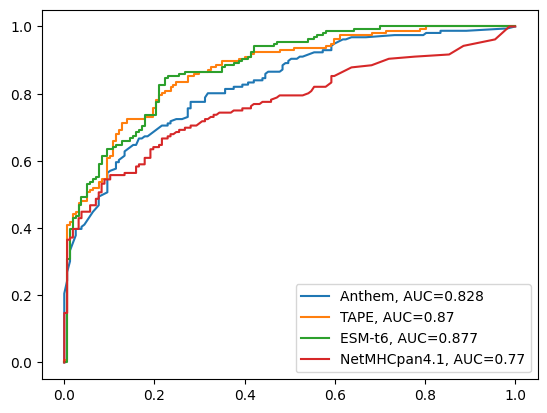

In [8]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

#data_8_mer = data_grouped[0]
#data_by_hla = data_8_mer[data_8_mer['HLA'] == "HLA-A*11:01"] # dividimos 
#data_by_hla = data_8_mer[data_8_mer['HLA'] == "HLA-B*27:05"] # dividimos 
#plot_ROC(data_by_hla)

hla = "HLA-B*27:05"

for data_k_mer in data_grouped:
    data_by_hla = data_k_mer[data_k_mer['HLA'] == hla] # dividimos 
    plot_ROC(data_by_hla)

